In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv('simulation_results.csv')

# Show first few rows
print(df.head())

         W1        W2         R         t  sigma_max       mass  runtime
0  0.453176  0.109103  0.050891  0.018525  33.511278  38.817408   22.156
1  0.545083  0.173166  0.049431  0.014302  57.556616  41.342222   26.774
2  0.511916  0.132664  0.043735  0.017039  42.156568  45.060976   24.496
3  0.521147  0.145586  0.056524  0.018902  36.736828  51.257317   24.262
4  0.448400  0.147370  0.051096  0.016280  47.511308  31.631060   19.959


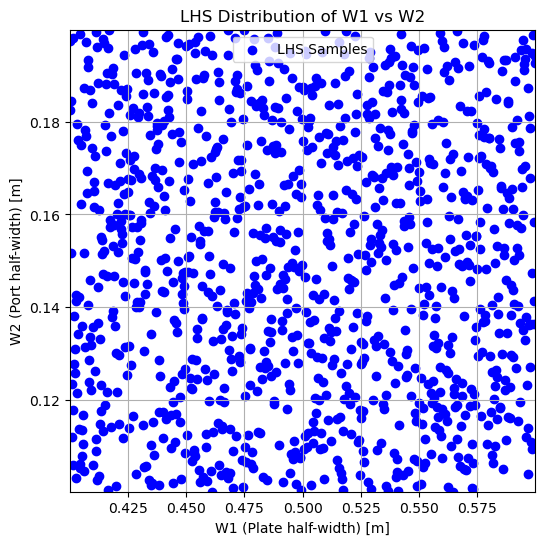

In [3]:
import matplotlib.pyplot as plt

# Choose two variables from your actual dataset
x = df['W1']
y = df['W2']

plt.figure(figsize=(6, 6))
plt.scatter(x, y, color='blue', label='LHS Samples')
plt.xlabel('W1 (Plate half-width) [m]')
plt.ylabel('W2 (Port half-width) [m]')
plt.title('LHS Distribution of W1 vs W2')
plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max())
plt.grid(True)
plt.legend()
plt.show()


In [4]:
from scipy.stats import chisquare
import numpy as np

def check_uniformity(series, bins=10):
    counts, _ = np.histogram(series, bins=bins)
    expected = [len(series) / bins] * bins
    chi2_stat, p = chisquare(counts, f_exp=expected)
    return chi2_stat, p

for col in df.columns:
    stat, p = check_uniformity(df[col])
    print(f"{col}: chi2 = {stat:.2f}, p = {p:.3f}")

W1: chi2 = 0.02, p = 1.000
W2: chi2 = 0.05, p = 1.000
R: chi2 = 0.07, p = 1.000
t: chi2 = 0.00, p = 1.000
sigma_max: chi2 = 1046.73, p = 0.000
mass: chi2 = 367.78, p = 0.000
runtime: chi2 = 540.25, p = 0.000


Understanding the Chi-Squared Test Results
The Chi-Squared Test for Goodness-of-Fit is a statistical method used to assess whether the observed frequency distribution of a variable differs significantly from an expected distribution — in this case, a uniform distribution (which is what Latin Hypercube Sampling (LHS) aims to achieve for input variables).

📊 What the Values Mean:

Variable	Chi² Value	p-value	Interpretation
W1	0.02	1.000	Uniformly distributed
W2	0.05	1.000	Uniformly distributed
R	0.07	1.000	Uniformly distributed
t	0.00	1.000	Uniformly distributed
σmax	1046.73	0.000	Not uniformly distributed
mass	367.78	0.000	Not uniformly distributed
runtime	540.25	0.000	Not uniformly distributed
🧪 1. The Chi-Squared Statistic (χ²)
The chi-squared value tells us how different the observed counts in each bin are from what we'd expect if the data were perfectly uniform:

A low chi² value means the observed values are very close to the expected uniform distribution.
A high chi² value means there’s a big difference — the data is not uniformly spread.
📈 2. The p-value
The p-value is the probability that we would observe a test statistic as extreme as (or more than) the current one, assuming the null hypothesis is true.

Null hypothesis (H₀): The data is uniformly distributed.
If p > 0.05, we fail to reject H₀ → the data is consistent with uniformity.
If p < 0.05, we reject H₀ → the data is not uniform.
✅ Interpretation of Your Results:
Input Variables (W1, W2, R, t):

All have very low chi² values and p = 1.000, indicating excellent agreement with uniformity.
✅ This confirms that your Latin Hypercube Sampling (LHS) correctly stratified the input space across these variables.
Output Variables (σmax, mass, runtime):

All have very high chi² values and p = 0.000, strongly indicating non-uniform distributions.
✅ This is expected and normal, since LHS does not control the output — these are shaped by the underlying physics and model behavior (nonlinear responses, constraints, etc.).

"The chi-squared test was used to verify the marginal uniformity of each variable. The p-value represents the probability of obtaining the observed distribution under the assumption of a uniform distribution. A p-value of 1.000 for all input variables (W1, W2, R, t) confirms that Latin Hypercube Sampling was successful in uniformly sampling the design space. High chi² values and p-values below 0.05 for output variables (σmax, mass, runtime) indicate that these distributions are non-uniform, as expected due to the nonlinear nature of the physical simulation."